# Modeling balancing ,active Learning, and ensemble learning


### Import Libraries

In [20]:
# Import core libraries
import pandas as pd
import numpy as np

# Parallel computing
from joblib import effective_n_jobs

# Undersampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Preprocessing data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Active Learner
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

# Metrics computation
from IPython.core.display_functions import display
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, precision_score, roc_curve, plot_precision_recall_curve, roc_auc_score, auc, precision_recall_curve

# Models
from sklearn.ensemble import GradientBoostingClassifier

# Cross validation
from sklearn.model_selection import GridSearchCV

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

### Define Model Metrics

In [2]:
# Model evaluation metrics
model_eval = {
    'model': [],
    'recall': [],
    'f1_score': [],
    'accuracy_score': [],
    'precision_score': []
}

def add_model_eval(model, recall, f1_score, accuracy_score, precision_score):
    model_eval['model'].append(model)
    model_eval['recall'].append(f'{recall: .2f}')
    model_eval['f1_score'].append(f'{f1_score: .2f}')
    model_eval['accuracy_score'].append(f'{accuracy_score: .2f}')
    model_eval['precision_score'].append(f'{precision_score: .2f}')

def view_models_eval(sort=False):
    eval_df = pd.DataFrame(model_eval)

    if sort:
        eval_df = eval_df.sort_values(by=['recall', 'f1_score'], ascending=[False, False])

    # display(eval_df.style.hide_index)
    display(eval_df)

### Load In Data

In [3]:
# # Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

# Load in data and transform data
# Load in data (transactions)
cc_transactions = pd.read_csv("../data/creditcard.csv", delimiter=",")

# Partition data into X and y
X_transactions = cc_transactions.drop(['Class'], axis=1)
y_transactions = cc_transactions['Class']


Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 492, 1: 492})


### Undersampling

In [ ]:
# Undersampling
rus = RandomUnderSampler(random_state=42)
# rus.fit(X_transactions,
#         y_transactions)
X_resampled, y_resampled = rus.fit_sample(X_transactions,
                                          y_transactions)
# Shape of old dataset vs. new dataset
print('Original dataset shape {}'.format(Counter(y_transactions)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

### Standardisation

In [ ]:
# Transforming the features 'Time' and 'Amount'
std_feat = ['Time',
            'Amount']
std_pipeline = Pipeline([('std_scaler',
                          StandardScaler())])

full_pipeline = ColumnTransformer([
    ('std_feat',
     std_pipeline,
     std_feat)],
    remainder='passthrough')

# Transform columns -> only for data that has the columns time and amount in them
X_resampled = full_pipeline.fit_transform(X_resampled)

### Active Learning

In [4]:
# Isolate our examples for our labeled dataset.
X_raw = X_resampled
y_raw = y_resampled.to_numpy()

n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0,
                                     high=n_labeled_examples + 1,
                                     size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw,
                   training_indices,
                   axis=0)
y_pool = np.delete(y_raw,
                   training_indices,
                   axis=0)

In [5]:
# Specify our core estimator along with its active learning model.
gbc = GradientBoostingClassifier()

# Initiate Active Learner
learner_uncertainty_sampling = ActiveLearner(estimator=gbc,
                                             X_training=X_train,
                                             y_training=y_train,
                                             query_strategy=uncertainty_sampling)
learner_margin_sampling = ActiveLearner(estimator=gbc,
                                        X_training=X_train,
                                        y_training=y_train,
                                        query_strategy=margin_sampling)
learner_entropy_sampling = ActiveLearner(estimator=gbc,
                                         X_training=X_train,
                                         y_training=y_train,
                                         query_strategy=entropy_sampling)

In [6]:
# Record our learner's score on the raw data.
unqueried_score_us = learner_uncertainty_sampling.score(X_raw, y_raw)
unqueried_score_ms = learner_margin_sampling.score(X_raw, y_raw)
unqueried_score_es = learner_entropy_sampling.score(X_raw, y_raw)
unqueried_score_us, unqueried_score_ms, unqueried_score_es

(0.7123983739837398, 0.7123983739837398, 0.7123983739837398)

In [7]:
# Isolate the data we'll need for plotting.
predictions_us = learner_uncertainty_sampling.predict(X_raw)
predictions_ms = learner_margin_sampling.predict(X_raw)
predictions_es = learner_entropy_sampling.predict(X_raw)

is_correct_us = (predictions_us == y_raw)
is_correct_ms = (predictions_ms == y_raw)
is_correct_es = (predictions_es == y_raw)

# predictions_us, predictions_ms, predictions_es
is_correct_us, is_correct_ms, is_correct_es

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [8]:
# Uncertainty Sampling
N_QUERIES = 150
performance_history_us = [unqueried_score_us]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
indice_us = []
X_pool_u = X_pool
y_pool_u = y_pool
for index in range(N_QUERIES):
    query_index_us, query_instance_us = learner_uncertainty_sampling.query(X_pool_u)
    indice_us.append(query_index_us)

    # Teach our Active Learner model the record it has requested.
    X_us, y_us = X_pool_u[query_index_us].reshape(1, -1), y_pool_u[query_index_us].reshape(1, )
    learner_uncertainty_sampling.teach(X=X_us, y=y_us)

    # Remove the queried instance from the unlabeled pool.
    X_pool_us, y_pool_us = np.delete(X_pool_u, query_index_us, axis=0), np.delete(y_pool_u, query_index_us)
    X_pool_u = X_pool_us
    y_pool_u = y_pool_us

    # Calculate and report our model's accuracy.
    model_accuracy_us = learner_uncertainty_sampling.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_us))

    # Save our model's performance for plotting.
    performance_history_us.append(model_accuracy_us)

Accuracy after query 1: 0.8313
Accuracy after query 2: 0.8933
Accuracy after query 3: 0.9065
Accuracy after query 4: 0.9045
Accuracy after query 5: 0.8669
Accuracy after query 6: 0.8608
Accuracy after query 7: 0.8608
Accuracy after query 8: 0.8608
Accuracy after query 9: 0.8628
Accuracy after query 10: 0.8628
Accuracy after query 11: 0.8628
Accuracy after query 12: 0.8628
Accuracy after query 13: 0.8628
Accuracy after query 14: 0.8628
Accuracy after query 15: 0.8628
Accuracy after query 16: 0.8628
Accuracy after query 17: 0.8628
Accuracy after query 18: 0.8628
Accuracy after query 19: 0.8628
Accuracy after query 20: 0.8628
Accuracy after query 21: 0.8628
Accuracy after query 22: 0.8628
Accuracy after query 23: 0.8628
Accuracy after query 24: 0.8628
Accuracy after query 25: 0.8628
Accuracy after query 26: 0.8628
Accuracy after query 27: 0.8628
Accuracy after query 28: 0.8628
Accuracy after query 29: 0.8628
Accuracy after query 30: 0.8628
Accuracy after query 31: 0.8628
Accuracy after qu

In [9]:
# Margin Sampling
N_QUERIES = 150
performance_history_ms = [unqueried_score_ms]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
indice_ms = []
X_pool_m = X_pool
y_pool_m = y_pool
for index in range(N_QUERIES):
    query_index_ms, query_instance_ms = learner_margin_sampling.query(X_pool_m)
    indice_ms.append(query_index_ms)

    # Teach our Active Learner model the record it has requested.
    X_ms, y_ms = X_pool[query_index_ms].reshape(1, -1), y_pool[query_index_ms].reshape(1, )
    learner_margin_sampling.teach(X=X_ms, y=y_ms)

    # Remove the queried instance from the unlabeled pool.
    X_pool_ms, y_pool_ms = np.delete(X_pool_m, query_index_ms, axis=0), np.delete(y_pool_m, query_index_ms)
    X_pool_m = X_pool_ms
    y_pool_m = y_pool_ms


    # Calculate and report our model's accuracy.
    model_accuracy_ms = learner_margin_sampling.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_ms))

    # Save our model's performance for plotting.
    performance_history_ms.append(model_accuracy_ms)

Accuracy after query 1: 0.8862
Accuracy after query 2: 0.8984
Accuracy after query 3: 0.8984
Accuracy after query 4: 0.9299
Accuracy after query 5: 0.9035
Accuracy after query 6: 0.8455
Accuracy after query 7: 0.8455
Accuracy after query 8: 0.8455
Accuracy after query 9: 0.8455
Accuracy after query 10: 0.8455
Accuracy after query 11: 0.9146
Accuracy after query 12: 0.9146
Accuracy after query 13: 0.9187
Accuracy after query 14: 0.9187
Accuracy after query 15: 0.9187
Accuracy after query 16: 0.9187
Accuracy after query 17: 0.9187
Accuracy after query 18: 0.9187
Accuracy after query 19: 0.9187
Accuracy after query 20: 0.9187
Accuracy after query 21: 0.9187
Accuracy after query 22: 0.9187
Accuracy after query 23: 0.9177
Accuracy after query 24: 0.9177
Accuracy after query 25: 0.9187
Accuracy after query 26: 0.9187
Accuracy after query 27: 0.9187
Accuracy after query 28: 0.9187
Accuracy after query 29: 0.9187
Accuracy after query 30: 0.9187
Accuracy after query 31: 0.9187
Accuracy after qu

In [10]:
# Entropy Sampling
N_QUERIES = 150
performance_history_es = [unqueried_score_es]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
indice_es = []
X_pool_e = X_pool
y_pool_e = y_pool
for index in range(N_QUERIES):
    query_index_es, query_instance_es = learner_entropy_sampling.query(X_pool_e)
    indice_es.append(query_index_es)

    # Teach our Active Learner model the record it has requested.
    X_es, y_es = X_pool[query_index_es].reshape(1, -1), y_pool[query_index_es].reshape(1, )
    learner_entropy_sampling.teach(X=X_es, y=y_es)

    # Remove the queried instance from the unlabeled pool.
    X_pool_es, y_pool_es = np.delete(X_pool_e, query_index_es, axis=0), np.delete(y_pool_e, query_index_es)
    X_pool_e = X_pool_es
    y_pool_e = y_pool_es

    # Calculate and report our model's accuracy.
    model_accuracy_es = learner_entropy_sampling.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy_es))

    # Save our model's performance for plotting.
    performance_history_es.append(model_accuracy_es)

Accuracy after query 1: 0.7470
Accuracy after query 2: 0.7988
Accuracy after query 3: 0.8862
Accuracy after query 4: 0.8943
Accuracy after query 5: 0.8963
Accuracy after query 6: 0.8242
Accuracy after query 7: 0.8242
Accuracy after query 8: 0.8242
Accuracy after query 9: 0.8242
Accuracy after query 10: 0.8242
Accuracy after query 11: 0.8963
Accuracy after query 12: 0.8262
Accuracy after query 13: 0.8963
Accuracy after query 14: 0.8963
Accuracy after query 15: 0.8262
Accuracy after query 16: 0.8262
Accuracy after query 17: 0.8262
Accuracy after query 18: 0.8262
Accuracy after query 19: 0.8262
Accuracy after query 20: 0.8262
Accuracy after query 21: 0.8963
Accuracy after query 22: 0.8963
Accuracy after query 23: 0.8963
Accuracy after query 24: 0.8963
Accuracy after query 25: 0.8963
Accuracy after query 26: 0.8963
Accuracy after query 27: 0.8963
Accuracy after query 28: 0.8963
Accuracy after query 29: 0.8963
Accuracy after query 30: 0.8963
Accuracy after query 31: 0.8963
Accuracy after qu

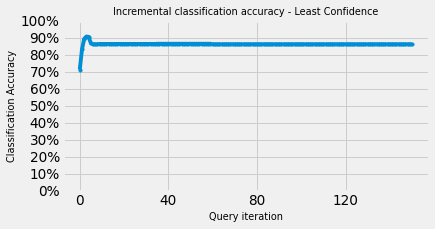

In [11]:
# Plot our performance over time
plt.style.use('fivethirtyeight')
fig_us, ax_us = plt.subplots(figsize=(6, 3), dpi=70)

ax_us.plot(performance_history_us)
ax_us.scatter(range(len(performance_history_us)), performance_history_us, s=13)

ax_us.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax_us.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax_us.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax_us.set_ylim(bottom=0, top=1)
ax_us.grid(True)

ax_us.set_title('Incremental classification accuracy - Least Confidence', fontsize=10)
ax_us.set_xlabel('Query iteration', fontsize=10)
ax_us.set_ylabel('Classification Accuracy', fontsize=10)

plt.show()

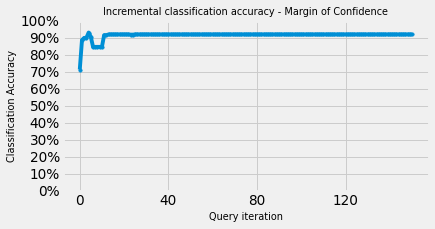

In [12]:
# Plot our performance over time
fig_ms, ax_ms = plt.subplots(figsize=(6, 3), dpi=70)

ax_ms.plot(performance_history_ms)
ax_ms.scatter(range(len(performance_history_ms)), performance_history_ms, s=13)

ax_ms.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax_ms.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax_ms.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax_ms.set_ylim(bottom=0, top=1)
ax_ms.grid(True)

ax_ms.set_title('Incremental classification accuracy - Margin of Confidence', fontsize=10)
ax_ms.set_xlabel('Query iteration', fontsize=10)
ax_ms.set_ylabel('Classification Accuracy', fontsize=10)

plt.show()

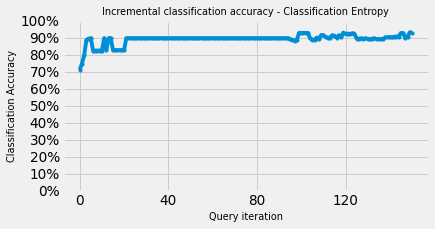

In [13]:
# Plot our performance over time
fig_es, ax_es = plt.subplots(figsize=(6, 3), dpi=70)

ax_es.plot(performance_history_es)
ax_es.scatter(range(len(performance_history_es)), performance_history_es, s=13)

ax_es.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax_es.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax_es.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax_es.set_ylim(bottom=0, top=1)
ax_es.grid(True)

ax_es.set_title('Incremental classification accuracy - Classification Entropy', fontsize=10)
ax_es.set_xlabel('Query iteration', fontsize=10)
ax_es.set_ylabel('Classification Accuracy', fontsize=10)

plt.show()

### Data Partitioning (Training supplied by AL, test and validation by train test split)

In [14]:
# Selecting instances for training (us)
indx_us = [index for sublist in indice_us for index in sublist]
training_indx_us = [ix for ix in training_indices]
X_training_us = np.array(X_raw)[indx_us + training_indx_us]
y_training_us =  np.array(y_raw)[indx_us + training_indx_us]

# Selecting instances for training (ms)
indx_ms = [index for sublist in indice_ms for index in sublist]
training_indx_ms = [ix for ix in training_indices]
X_training_ms = np.array(X_raw)[indx_ms + training_indx_ms]
y_training_ms =  np.array(y_raw)[indx_ms + training_indx_ms]

# Selecting instances for training (es)
indx_es = [index for sublist in indice_es for index in sublist]
training_indx_es = [ix for ix in training_indices]
X_training_es = np.array(X_raw)[indx_es + training_indx_es]
y_training_es =  np.array(y_raw)[indx_es + training_indx_es]

# We are now left with test and validation data. This needs to be partitioned into test and validation.
X_test_us, X_val_us, y_test_us, y_val_us = train_test_split(X_pool_u,
                                                            y_pool_u,
                                                            test_size=0.1)
X_test_ms, X_val_ms, y_test_ms, y_val_ms = train_test_split(X_pool_m,
                                                            y_pool_m,
                                                            test_size=0.1)
X_test_es, X_val_es, y_test_es, y_val_es = train_test_split(X_pool_e,
                                                            y_pool_e,
                                                            test_size=0.1)

### Cross Validation

In [15]:
# Boosting Classifier
gradientB = GradientBoostingClassifier()

param_grid_gbc = {
    'n_estimators': list(range(100, 150, 10)),
    'learning_rate': [0.01, 0.025, 0.05, 0.075],
    'max_features':['log2','sqrt', 'auto'],
    'subsample':[0.5, 0.85, 0.95]
}

# Initialise GridSearchCV (us)
CV_gbc_us = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5)
CV_gbc_us.fit(X_val_us, y_val_us)

# Initialise GridSearchCV (ms)
CV_gbc_ms = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5)
CV_gbc_ms.fit(X_val_ms, y_val_ms)

# Initialise GridSearchCV (es)
CV_gbc_es = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5)
CV_gbc_es.fit(X_val_es, y_val_es)

# GridSearch results for all three models
CV_gbc_us.best_params_, CV_gbc_ms.best_params_, CV_gbc_es.best_params_

({'learning_rate': 0.05,
  'max_features': 'sqrt',
  'n_estimators': 110,
  'subsample': 0.85},
 {'learning_rate': 0.05,
  'max_features': 'log2',
  'n_estimators': 100,
  'subsample': 0.5},
 {'learning_rate': 0.01,
  'max_features': 'sqrt',
  'n_estimators': 120,
  'subsample': 0.95})

### Modeling Gradient Boost

In [16]:
# Initialize random forest and use GridSearchCV parameters to fill in parameters of random forest - Uncertainty Sampling
n_thread =  effective_n_jobs(-1)
gbc_us = GradientBoostingClassifier(random_state=42, n_estimators = 110, learning_rate = 0.05, max_features = 'sqrt', subsample =0.85)

# Train Model
gbc_us.fit(X_training_us, y_training_us)

# Predict using test data
y_pred_gbc_us = gbc_us.predict(X_test_us)

# Show model performance
add_model_eval('Gradient Boosting Classifier - Uncertainty Sampling', recall_score(y_test_us, y_pred_gbc_us), f1_score(y_test_us, y_pred_gbc_us), accuracy_score(y_test_us, y_pred_gbc_us), precision_score(y_test_us, y_pred_gbc_us))
view_models_eval()

,model,recall,f1_score,accuracy_score,precision_score
0,Gradient Boosting Classifier - Uncertainty Sam...,0.70,0.82,0.85,1.00


In [17]:
# Initialize random forest and use GridSearchCV parameters to fill in parameters of random forest - Margin Sampling
gbc_ms = GradientBoostingClassifier(random_state=42, n_estimators = 100, learning_rate = 0.05, max_features = 'log2', subsample =0.5)

# Train Model
gbc_ms.fit(X_training_ms, y_training_ms)

# Predict using test data
y_pred_gbc_ms = gbc_ms.predict(X_test_ms)

# Show model performance
add_model_eval('Gradient Boosting Classifier - Margin Sampling', recall_score(y_test_ms, y_pred_gbc_ms), f1_score(y_test_ms, y_pred_gbc_ms), accuracy_score(y_test_ms, y_pred_gbc_ms), precision_score(y_test_ms, y_pred_gbc_ms))
view_models_eval()

,model,recall,f1_score,accuracy_score,precision_score
0,Gradient Boosting Classifier - Uncertainty Sam...,0.70,0.82,0.85,1.00
1,Gradient Boosting Classifier - Margin Sampling,0.45,0.62,0.75,1.00


In [18]:
# Initialize random forest and use GridSearchCV parameters to fill in parameters of random forest - Entropy Sampling
gbc_es = GradientBoostingClassifier(random_state=42, n_estimators = 120, learning_rate = 0.01, max_features = 'sqrt', subsample =0.95)

# Train Model
gbc_es.fit(X_training_es, y_training_es)

# Predict using test data
y_pred_gbc_es = gbc_es.predict(X_test_es)

# Show model performance
add_model_eval('Gradient Boosting Classifier - Entropy Sampling', recall_score(y_test_es, y_pred_gbc_es), f1_score(y_test_es, y_pred_gbc_es), accuracy_score(y_test_es, y_pred_gbc_es), precision_score(y_test_es, y_pred_gbc_es))
view_models_eval()

,model,recall,f1_score,accuracy_score,precision_score
0,Gradient Boosting Classifier - Uncertainty Sam...,0.70,0.82,0.85,1.00
1,Gradient Boosting Classifier - Margin Sampling,0.45,0.62,0.75,1.00
2,Gradient Boosting Classifier - Entropy Sampling,0.83,0.91,0.93,1.00


### Model metrics

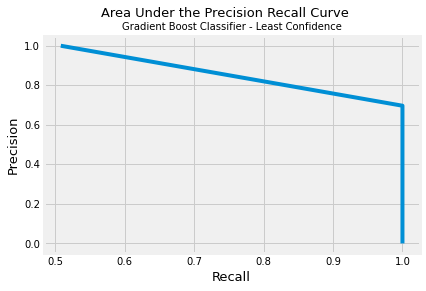

In [22]:
# Generate precision recall curve values: precision, recall, thresholds
precision_gb_us, recall_gb_us, thresholds_gb_us = precision_recall_curve(y_test_us, y_pred_gbc_us)
auc_precision_recall_gb_us = auc(recall_gb_us, precision_gb_us)

# Plot ROC curve
plt.plot(precision_gb_us, recall_gb_us, label="AUC="+str(auc_precision_recall_gb_us))
plt.ylabel('Precision', fontsize=13)
plt.xlabel('Recall', fontsize=13)
plt.title('Gradient Boost Classifier - Least Confidence', fontsize=10)
plt.suptitle('Area Under the Precision Recall Curve', fontsize=13)
plt.show()

In [23]:
auc_precision_recall_gb_us

0.9253627084114397

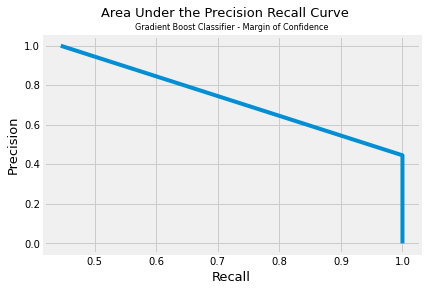

In [24]:
# Generate precision recall curve values: precision, recall, thresholds
precision_gb_ms, recall_gb_ms, thresholds_gb_ms = precision_recall_curve(y_test_ms, y_pred_gbc_ms)
auc_precision_recall_gb_ms = auc(recall_gb_ms, precision_gb_ms)

# Plot ROC curve
plt.plot(precision_gb_ms, recall_gb_ms, label="AUC="+str(auc_precision_recall_gb_ms))
plt.ylabel('Precision', fontsize=13)
plt.xlabel('Recall', fontsize=13)
plt.title('Gradient Boost Classifier - Margin of Confidence', fontsize=8)
plt.suptitle('Area Under the Precision Recall Curve', fontsize=13)
plt.show()

In [25]:
auc_precision_recall_gb_ms

0.846215963047902

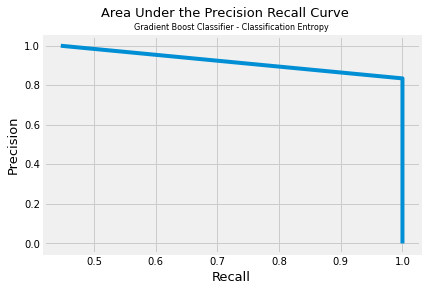

In [27]:
# Generate precision recall curve values: precision, recall, thresholds
precision_gb_es, recall_gb_es, thresholds_gb_es = precision_recall_curve(y_test_es, y_pred_gbc_es)
auc_precision_recall_gb_es = auc(recall_gb_es, precision_gb_es)

# Plot ROC curve
plt.plot(precision_gb_es, recall_gb_es, label="AUC="+str(auc_precision_recall_gb_es))
plt.ylabel('Precision', fontsize=13)
plt.xlabel('Recall', fontsize=13)
plt.title('Gradient Boost Classifier - Classification Entropy', fontsize=8)
plt.suptitle('Area Under the Precision Recall Curve', fontsize=13)
plt.show()

In [31]:
auc_precision_recall_gb_es

0.9542806881948973

In [26]:
tn_us, fp_us, fn_us, tp_us = confusion_matrix(y_test_us, y_pred_gbc_us).ravel()
specificity_us = tn_us / (tn_us+fp_us)
specificity_us

1.0

In [27]:
tn_ms, fp_ms, fn_ms, tp_ms = confusion_matrix(y_test_ms, y_pred_gbc_ms).ravel()
specificity_ms = tn_ms / (tn_ms+fp_ms)
specificity_ms

1.0

In [28]:
tn_es, fp_es, fn_es, tp_es = confusion_matrix(y_test_es, y_pred_gbc_es).ravel()
specificity_es = tn_es / (tn_es+fp_es)
specificity_es

1.0

In [33]:
X_test_es

array([[ 1.36168005,  0.01678381,  1.64137011, ..., -0.45914113,
         0.08151831, -0.04050174],
       [ 0.40561356, -0.44799922,  2.02709905, ...,  0.13668083,
        -0.09346889, -0.06258692],
       [ 0.12410972,  0.96899801, -5.83919162, ...,  0.28243502,
         0.10488602,  0.2544171 ],
       ...,
       [-0.90825864, -0.36209872,  1.41207405, ...,  1.30066885,
        -0.10589886, -0.01603302],
       [ 1.21170311, -0.45160848,  0.90863666, ...,  0.21050976,
         0.6487048 ,  0.36022433],
       [ 1.33445321, -0.38393477,  1.96468351, ..., -0.51073099,
        -0.024165  , -0.07145941]])